In [208]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import os
import sqlite3
%matplotlib inline
import plotly.express as px
from plotly import graph_objs as go
import plotly.figure_factory as ff

# Model
# Compare the Logistic Regression Model V.S. Base Rate Model V.S. Random Forest Model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings("ignore")

import toolkit as tool

import os

os.system('date')

dom 10 dez 2023 00:02:04 -03


0

### Objective

The data is for company X which is trying to control attrition. There are two sets of data: “Existing employees” and “Employees who have left”. Following attributes are available for every employee.
 - Satisfaction Level
 - Last evaluation
 - Number of projects
 - Average monthly hours
 - Time spent at the company
 - Whether they have had a work accident
 - Whether they have had a promotion in the last 5 years
 - Departments (column sales)
 - Salary
 - Whether the employee has left

In [209]:
# loading dataset.
df = pd.read_csv('../datasets/HR_COM1_tomodel.csv')
df.head()

,Emp ID,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,dept,salary
0,1,0.38,0.53,2,157,3,0,1,0,7,1
1,2,0.80,0.86,5,262,6,0,1,0,7,2
2,3,0.11,0.88,7,272,4,0,1,0,7,2
3,4,0.72,0.87,5,223,5,0,1,0,7,1
4,5,0.37,0.52,2,159,3,0,1,0,7,1


In [210]:
shape_rows = df.shape[0]
shape_columns = df.shape[1]

print(f'Dataset rows = {shape_rows} and columns = {shape_columns}.')

Dataset rows = 14999 and columns = 11.


### X and y 

In [211]:
# Set the input X to the K-Means.
X = df.drop(columns=['turnover'])
y = df['turnover']

In [212]:
# Method of inertia to find the ideal of clusters.
inertia = []
for k in range(1, 11):
    clf = KMeans(n_clusters = k , random_state= 123)
    clf.fit(X)
    inertia.append(clf.inertia_)

In [213]:
pd.DataFrame({"k":list(range(1 , 11)),
              "inércia": inertia})

,k,inércia
0,1,2.812313e+11
1,2,7.033611e+10
2,3,3.128240e+10
3,4,1.761497e+10
4,5,1.128610e+10
5,6,7.851759e+09
6,7,5.782378e+09
7,8,4.435138e+09
8,9,3.511185e+09
9,10,2.849958e+09


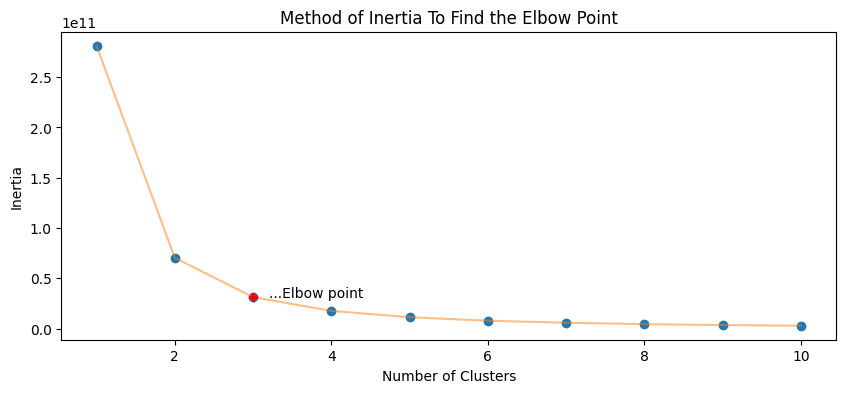

In [214]:
plt.figure(1 , figsize = (10 ,4))
plt.title('Method of Inertia To Find the Elbow Point')
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')

# adicionado depois... ;-)
plt.plot(3 , inertia[2] , 'P', alpha = 1, color = 'red')
plt.text(3 + 0.2 , inertia[2] , '...Elbow point')

plt.show()

In [215]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Employee Turnover
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df[df.turnover==1][["satisfaction","evaluation"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

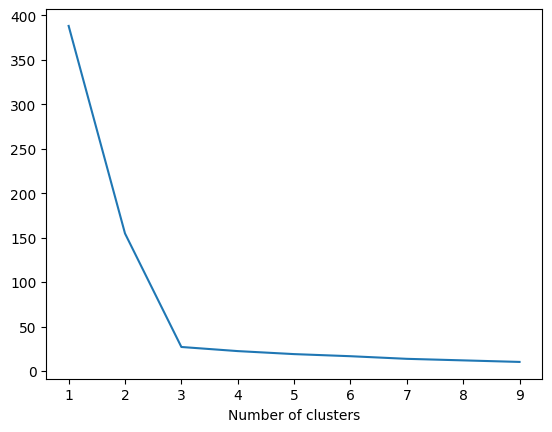

In [216]:
# Determine number of clusters with K-means elbow method
# The arc of the elbow shows that number 3 is our best fit and as thus we would create  3 clusters of employee
sse={}
br = df[df.turnover==1][["satisfaction","evaluation"]]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df[df.turnover==1][["satisfaction","evaluation"]])

    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [217]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter(
    x=df["satisfaction"], y=df["evaluation"],
    mode='markers',
    marker=dict(
        color= kmeans_colors,
        opacity=[1, 0.8, 0.6, 0.4],
        size=[40, 60, 80, 100],
    )
)])
fig.update_layout(title_text='Employee Cluster Chart')
fig.show()

### Train and Test features

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

### Modeling

#### Logistic Regression V.S. Random Forest V.S. Decision Tree V.S. AdaBoost Model


In [219]:
model = LogisticRegression(penalty='l2', C=1)

model.fit(X_train, y_train)
print ("Logistic accuracy is %2.2f" % accuracy_score(y_test, model.predict(X_test)))

Logistic accuracy is 0.75


In [220]:
# Using 10 fold Cross-Validation to train our Logistic Regression Model
kfold = model_selection.KFold(n_splits=10)
modelCV = LogisticRegression(class_weight = "balanced")
scoring = 'roc_auc'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.786 (0.025)


In [221]:
# NOTE: By adding in "class_weight = balanced", the Logistic Auc increased by about 10%! This adjusts the threshold value
logis = LogisticRegression(class_weight = "balanced")
logis.fit(X_train, y_train)
print ("\n\n ---Logistic Model---")
logit_roc_auc = roc_auc_score(y_test, logis.predict(X_test))
print ("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(y_test, logis.predict(X_test)))



 ---Logistic Model---
Logistic AUC = 0.70
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      1714
           1       0.40      0.73      0.52       536

    accuracy                           0.68      2250
   macro avg       0.64      0.70      0.64      2250
weighted avg       0.77      0.68      0.70      2250



In [222]:
# Decision Tree Model
dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)
print ("\n\n ---Decision Tree Model---")
dt_roc_auc = roc_auc_score(y_test, dtree.predict(X_test))
print ("Decision Tree AUC = %2.2f" % dt_roc_auc)
print(classification_report(y_test, dtree.predict(X_test)))



 ---Decision Tree Model---
Decision Tree AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1714
           1       0.92      0.98      0.95       536

    accuracy                           0.97      2250
   macro avg       0.96      0.98      0.97      2250
weighted avg       0.98      0.97      0.97      2250



In [223]:
# Random Forest Model
rf = RandomForestClassifier(
    n_estimators=10000, 
    max_depth=None, 
    min_samples_split=10, 
    class_weight="balanced",
    n_jobs=-1
    #min_weight_fraction_leaf=0.02 
    )
rf.fit(X_train, y_train)
print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))

# Evaluate predictions
print(f'score:....................: {round(accuracy_score(y_test, rf.predict(X_test)), 4)*100} %')



 ---Random Forest Model---
Random Forest AUC = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1714
           1       1.00      1.00      1.00       536

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250

score:....................: 99.91 %


In [224]:
list_name_features = []
index = 1

for feat, importance in zip(X.columns, rf.feature_importances_):
    importance = round(importance*100, 2)
    print(f'{index} - feature: {feat}, importance: {importance} %')
    list_name_features.append(feat)
    index += 1

1 - feature: Emp ID, importance: 42.75 %
2 - feature: satisfaction, importance: 19.31 %
3 - feature: evaluation, importance: 6.14 %
4 - feature: projectCount, importance: 9.66 %
5 - feature: averageMonthlyHours, importance: 7.03 %
6 - feature: yearsAtCompany, importance: 14.13 %
7 - feature: workAccident, importance: 0.38 %
8 - feature: promotion, importance: 0.06 %
9 - feature: dept, importance: 0.3 %
10 - feature: salary, importance: 0.24 %


In [225]:
list_feat_importances = list(rf.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

Emp ID.......: 42.75 %
satisfaction.......: 19.31 %
evaluation.......: 6.14 %
projectCount.......: 9.66 %
averageMonthlyHours.......: 7.03 %
yearsAtCompany.......: 14.13 %
workAccident.......: 0.38 %
promotion.......: 0.06 %
dept.......: 0.3 %
salary.......: 0.24 %


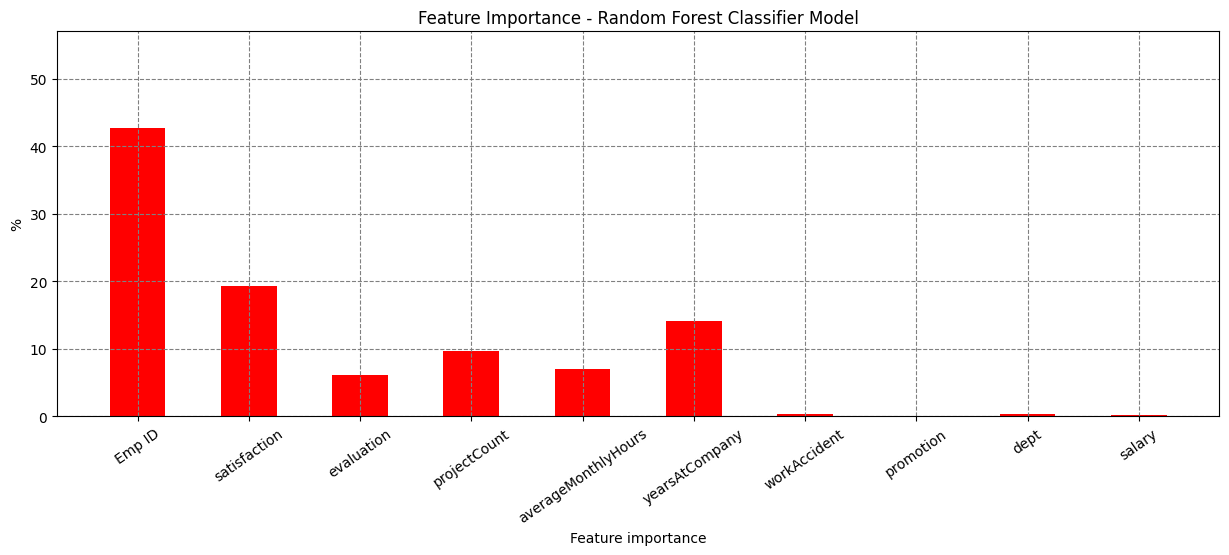

In [226]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,57)
plt.title("Feature Importance - Random Forest Classifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [227]:
# Ada Boost
ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
ada.fit(X_train,y_train)
print ("\n\n ---AdaBoost Model---")
ada_roc_auc = roc_auc_score(y_test, ada.predict(X_test))
print ("AdaBoost AUC = %2.2f" % ada_roc_auc)
print(classification_report(y_test, ada.predict(X_test)))



 ---AdaBoost Model---
AdaBoost AUC = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1714
           1       1.00      1.00      1.00       536

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



In [228]:
list_feat_importances = list(ada.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

Emp ID.......: 98.25 %
satisfaction.......: 1.5 %
evaluation.......: 0.0 %
projectCount.......: 0.25 %
averageMonthlyHours.......: 0.0 %
yearsAtCompany.......: 0.0 %
workAccident.......: 0.0 %
promotion.......: 0.0 %
dept.......: 0.0 %
salary.......: 0.0 %


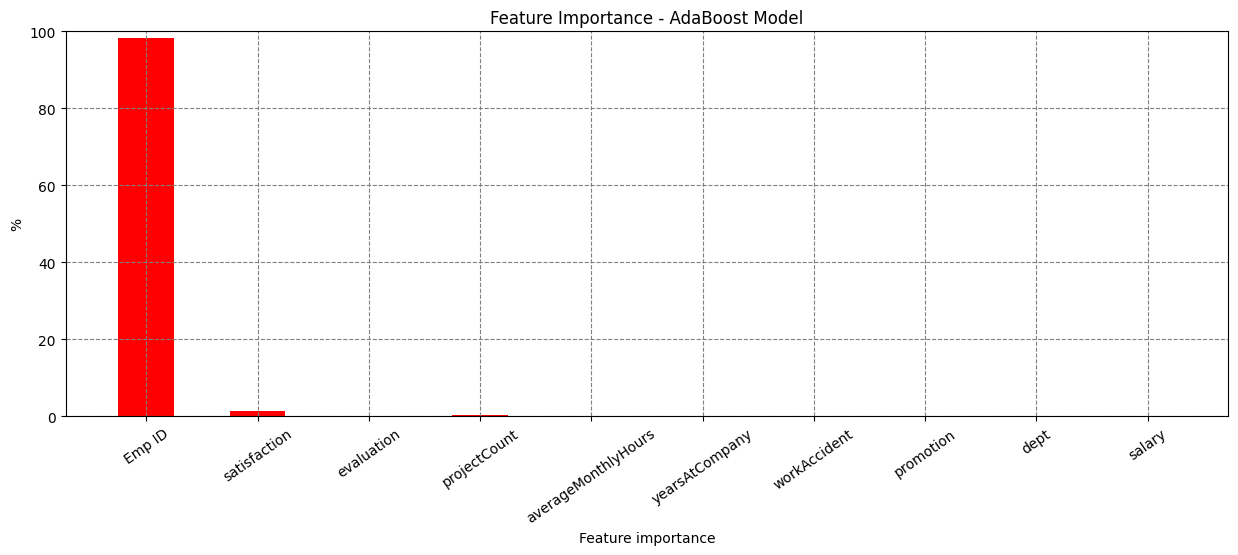

In [229]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - AdaBoost Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [230]:
# Create XGBoost model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

print ("\n\n ---XGBClassifier Model---")
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict(X_test))
print ("XGBClassifier AUC = %2.2f" % xgb_roc_auc)
print(classification_report(y_test, xgb_model.predict(X_test)))



 ---XGBClassifier Model---
XGBClassifier AUC = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1714
           1       1.00      1.00      1.00       536

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



In [231]:
list_feat_importances = list(xgb_model.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

Emp ID.......: 98.27 %
satisfaction.......: 1.01 %
evaluation.......: 0.06 %
projectCount.......: 0.06 %
averageMonthlyHours.......: 0.08 %
yearsAtCompany.......: 0.49 %
workAccident.......: 0.03 %
promotion.......: 0.0 %
dept.......: 0.0 %
salary.......: 0.0 %


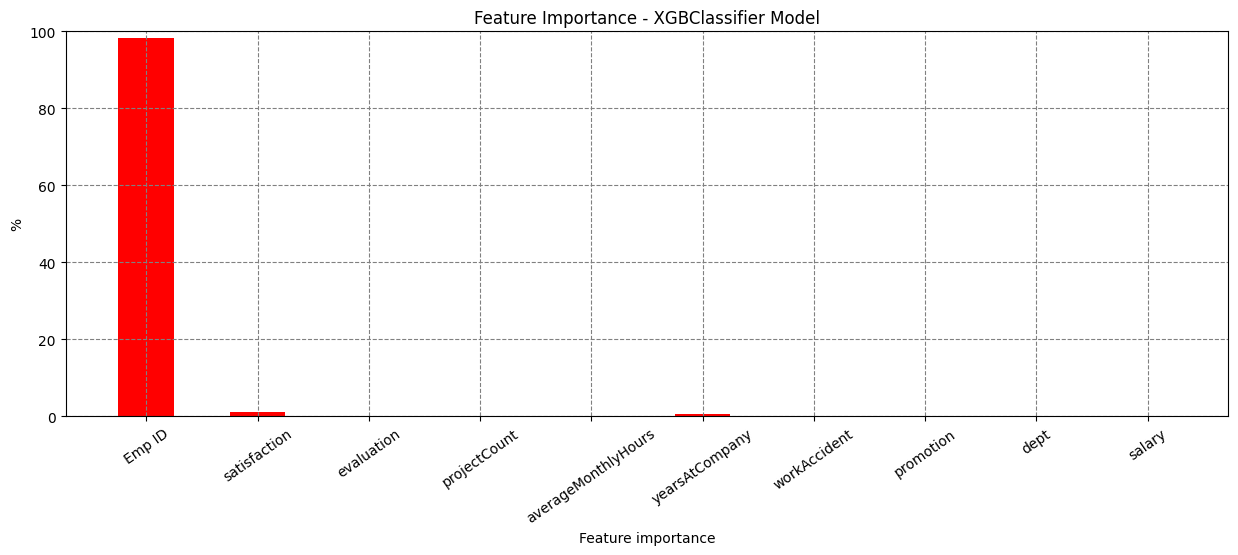

In [232]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - XGBClassifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [233]:
# Create CatBoost classifier
#cat_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', eval_metric='Accuracy')

from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier(
    iterations = 1000, # 1000 are ideal
    loss_function='MultiClass',
    bootstrap_type = "Bayesian",
    eval_metric = 'MultiClass',
    leaf_estimation_iterations = 100,
    random_strength = 0.5,
    depth = 7,
    l2_leaf_reg = 5,
    learning_rate=0.1,
    bagging_temperature = 0.5,
    thread_count=-1 # number of threads, setted all CPU cores
    #task_type = "GPU",
)

# Train the model
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

print ("\n\n ---CatBoostClassifier Model---")
cat_roc_auc = roc_auc_score(y_test, cat_model.predict(X_test))
print ("CatBoost AUC = %2.2f" % cat_roc_auc)
print(classification_report(y_test, cat_model.predict(X_test)))



 ---CatBoostClassifier Model---
CatBoost AUC = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1714
           1       1.00      1.00      1.00       536

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



In [234]:
list_feat_importances = list(cat_model.feature_importances_)
dict_feat_importances = {}

i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i] # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

Emp ID.......: 85.96 %
satisfaction.......: 4.09 %
evaluation.......: 1.35 %
projectCount.......: 1.85 %
averageMonthlyHours.......: 1.32 %
yearsAtCompany.......: 4.09 %
workAccident.......: 0.1 %
promotion.......: 0.0 %
dept.......: 0.9 %
salary.......: 0.32 %


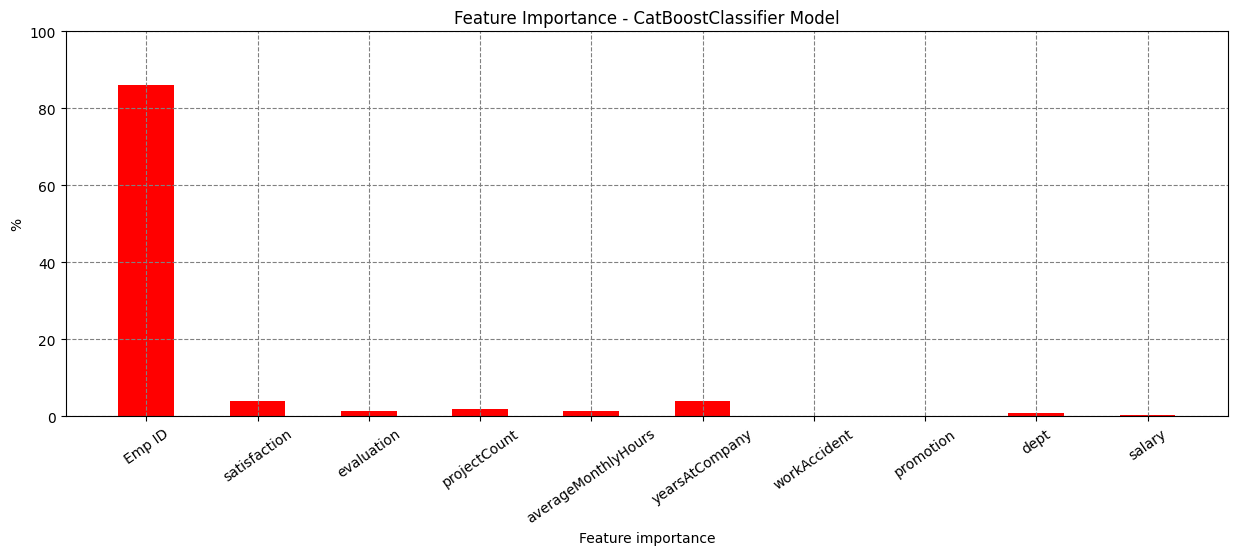

In [235]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - CatBoostClassifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

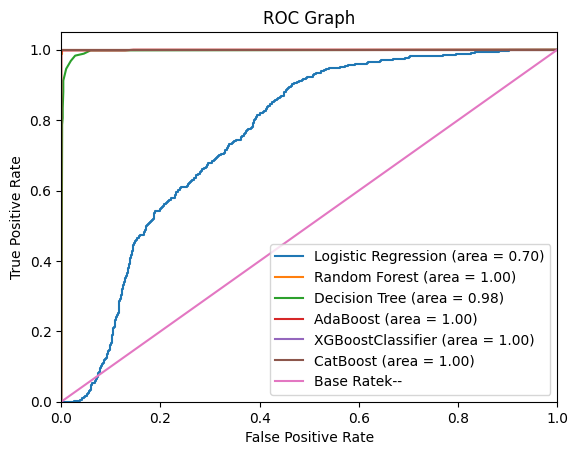

In [236]:
# Create ROC Graph
fpr, tpr, thresholds = roc_curve(y_test, logis.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dtree.predict_proba(X_test)[:,1])
ada_fpr, ada_tpr, ada_thresholds = roc_curve(y_test, ada.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
cat_fpr, cat_tpr, cat_thresholds = roc_curve(y_test, cat_model.predict_proba(X_test)[:,1])

plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# Plot Decision Tree ROC
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)

# Plot AdaBoost ROC
plt.plot(ada_fpr, ada_tpr, label='AdaBoost (area = %0.2f)' % ada_roc_auc)

# Plot XGBoostClassifier ROC
plt.plot(xgb_fpr, xgb_tpr, label='XGBoostClassifier (area = %0.2f)' % xgb_roc_auc)

# Plot XGBoostClassifier ROC
plt.plot(cat_fpr, cat_tpr, label='CatBoost (area = %0.2f)' % cat_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [253]:
# predicting the model output
y_pred_cat = cat_model.predict(X_test)

acc   = round(accuracy_score(y_test,y_pred_cat), 4)*100
score = round(metrics.precision_score(y_test, y_pred_cat, average='macro')*100, 2)
mae   = round(mean_absolute_error(y_test, y_pred_cat), 5)


print('catboost model:')
print(f"accuracy........:{acc}%")
print(f'score...........:{score}')
print(f"Mean Absolute Error: {mae}")

catboost model:
accuracy........:99.91%
score...........:99.94
Mean Absolute Error: 0.00089


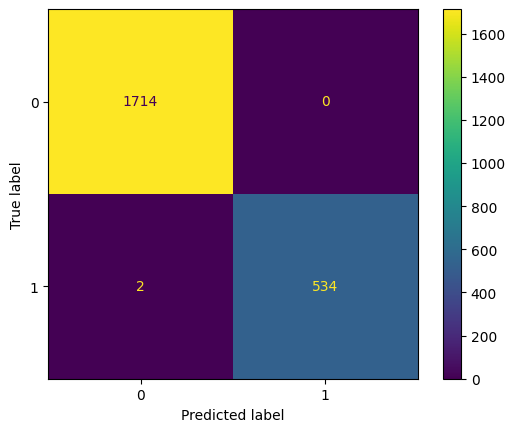

In [240]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix1  =confusion_matrix(y_test, y_pred_cat)
display = ConfusionMatrixDisplay(confusion_matrix1).plot()
plt.grid(False)
plt.show()


In [246]:
os.system('date')

dom 10 dez 2023 00:04:14 -03


0